In [4]:
#pip install calmap

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime as dt
import requests

##Import, set up data

Import the historic observations '''database''' and the table of hotspots for each trailhead

In [5]:
histObs1 = pd.read_csv('https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/cooking/EastSunsetWay_Obs_2019to2021.csv')
histObs2 = pd.read_csv('https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/cooking/MargaretsWay_Obs_2019to2021.csv')
histObs3 = pd.read_csv('https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/cooking/MountTeneriffe_Obs_2019to2021.csv')

frames = [histObs1,histObs2,histObs3]
histObs = pd.concat(frames,ignore_index=True)

trailheadHotspots = pd.read_csv('https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/trailheadHotspots/trailheadHotspots_Y2022_M1_D11.csv')

trailheadRef = pd.DataFrame()
trailheadRef_json = 'https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/trailheadsRef.json'
response = requests.get(trailheadRef_json)
trailheadRef = pd.DataFrame(response.json())

trailheadRef = trailheadRef.drop(columns=['Address','Latitude','Longitude'])
trailheadHotspots = trailheadHotspots.drop(columns=['countryCode','subnational1Code','subnational2Code','lat','lng','latestObsDt','locName','numSpeciesAllTime'])

In [6]:
##join trailheadRef with trailheadHotspots to get route names
##yes it is an anti-pattern
##I will fix

trailheadHotspots = pd.merge(
    left=trailheadHotspots,
    right=trailheadRef,
    left_on='StopName',
    right_on='StopName',
    how='left'
)
trailheadHotspots.head()

,locId,StopName,Route
0,L10128988,EastSunsetWay,IssaquahAlps
1,L10129014,EastSunsetWay,IssaquahAlps
2,L8365620,EastSunsetWay,IssaquahAlps
3,L8102503,EastSunsetWay,IssaquahAlps
4,L3352189,EastSunsetWay,IssaquahAlps


In [7]:
##make a giant dataframe of compounded observations. Feels like an anti-pattern but computers prefer structured data over looped references

histObsCompleat = pd.DataFrame()

for StopName in trailheadHotspots:
    for locId in trailheadHotspots.itertuples():
        histObsCompleat = pd.merge(
            left=histObs,
            right=trailheadHotspots,
            left_on='locId',
            right_on='locId',
            how='left'
        )

In [8]:
##cleanup
histObsCompleat['obsDt'] = histObsCompleat['obsDt'].astype('datetime64[ns]')
histObsCompleat['howMany'] = histObsCompleat['howMany'].fillna(1)
histObsCompleat['howMany'] = histObsCompleat['howMany'].astype('int32')
##add month,year and week of year
histObsCompleat['obsDt_year'] = pd.DatetimeIndex(histObsCompleat['obsDt']).year
histObsCompleat['obsDt_month'] = pd.DatetimeIndex(histObsCompleat['obsDt']).month
histObsCompleat['obsDt_week'] = histObsCompleat['obsDt'].dt.isocalendar().week

Build relative diversity map for each trailhead. Map is similar to Github's contribution map
x axis: trailhead name
y axis: week of year

https://towardsdatascience.com/create-githubs-style-contributions-plot-for-your-time-series-data-79df84ec93da

In [9]:
##frame of unique species seen each month
histObs_diversity = histObsCompleat.sort_values(by=['Route','StopName','obsDt_year','obsDt_month','obsDt_week'],ascending=True)
histObs_diversity.drop_duplicates(subset=['Route','StopName','obsDt_month','obsDt_week','comName'],keep='first')

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId,StopName,Route,obsDt_year,obsDt_month,obsDt_week
126,mallar3,Mallard,Anas platyrhynchos,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,2,47.529503,-122.039512,True,False,False,S51278518,ChiricoTrail_PooPooPoint,IssaquahAlps,2019,1,1
129,annhum,Anna's Hummingbird,Calypte anna,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,2,47.529503,-122.039512,True,False,False,S51278518,ChiricoTrail_PooPooPoint,IssaquahAlps,2019,1,1
132,bkcchi,Black-capped Chickadee,Poecile atricapillus,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,1,47.529503,-122.039512,True,False,False,S51278518,ChiricoTrail_PooPooPoint,IssaquahAlps,2019,1,1
135,chbchi,Chestnut-backed Chickadee,Poecile rufescens,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,1,47.529503,-122.039512,True,False,False,S51278518,ChiricoTrail_PooPooPoint,IssaquahAlps,2019,1,1
138,daejun,Dark-eyed Junco,Junco hyemalis,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,24,47.529503,-122.039512,True,False,False,S51278518,ChiricoTrail_PooPooPoint,IssaquahAlps,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,varthr,Varied Thrush,Ixoreus naevius,L4703260,Square Lake State Park,2020-12-24 15:49:00,3,47.480270,-122.684439,True,False,False,S77945298,MountTeneriffe,MountSi,2020,12,52
7998,foxspa,Fox Sparrow,Passerella iliaca,L4703260,Square Lake State Park,2020-12-24 15:49:00,1,47.480270,-122.684439,True,False,False,S77945298,MountTeneriffe,MountSi,2020,12,52
8000,daejun,Dark-eyed Junco,Junco hyemalis,L4703260,Square Lake State Park,2020-12-24 15:49:00,10,47.480270,-122.684439,True,False,False,S77945298,MountTeneriffe,MountSi,2020,12,52
8002,sonspa,Song Sparrow,Melospiza melodia,L4703260,Square Lake State Park,2020-12-24 15:49:00,6,47.480270,-122.684439,True,False,False,S77945298,MountTeneriffe,MountSi,2020,12,52


histObs_obsv = histObs.groupby(['obsDt_year','obsDt_month','obsDt_week'])['subId'].count()
histObs_obsv = pd.DataFrame(histObs_obsv)
histObs_birdCount = histObs.groupby(['obsDt_year','obsDt_month','obsDt_week','comName'])['howMany'].sum()
histObs_birdCount = pd.DataFrame(histObs_birdCount)


In [10]:
histObs_diversity = histObs_diversity.groupby(['Route','StopName','obsDt_month','obsDt_week'])['comName'].count()
histObs_diversity = pd.DataFrame(histObs_diversity)

In [11]:
histObs_diversity.index.set_names(["Route","Trailhead","month","week"], inplace=True)

In [12]:
histObs_diversity = histObs_diversity.reset_index()

In [34]:
##histObs_diversity['comName'].describe()
histObs_diversity['score'] = int
quartiles = histObs_diversity['comName'].quantile([0,0.15,0.25,0.35,0.5,0.75,0.85,0.95,1])

histObs_diversity.loc[histObs_diversity['comName'] < quartiles[0], 'score'] = 1
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0]) & (histObs_diversity['comName'] < quartiles[0.15]), 'score'] = 2
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.15]) & (histObs_diversity['comName'] < quartiles[0.25]), 'score'] = 3
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.25]) & (histObs_diversity['comName'] < quartiles[0.35]), 'score'] = 4
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.35]) & (histObs_diversity['comName'] < quartiles[0.5]), 'score'] = 5
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.5]) & (histObs_diversity['comName'] < quartiles[0.75]), 'score'] = 6
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.75]) & (histObs_diversity['comName'] < quartiles[0.85]), 'score'] = 7
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.85]) & (histObs_diversity['comName'] < quartiles[0.95]), 'score'] = 8
histObs_diversity.loc[(histObs_diversity['comName'] >= quartiles[0.95]) & (histObs_diversity['comName'] <= quartiles[1]), 'score'] = 9

In [136]:
##todo #12 for birds observed on a regular basis in counts greater than five, pull the monthly (+/- 15 day window) and substitute

<AxesSubplot:xlabel='week', ylabel='Route-Trailhead'>

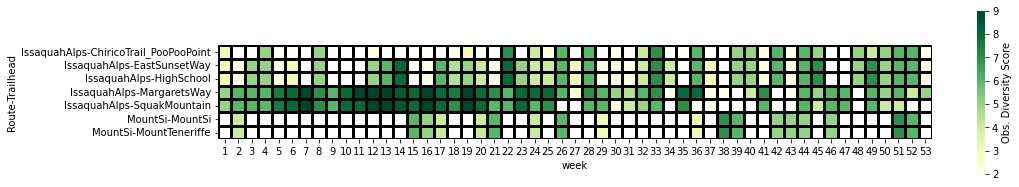

In [39]:
pivot_histDiversity = pd.pivot_table(histObs_diversity,values='score',index=['Route','Trailhead'],columns=['week'])

plt.figure(figsize=(16,3))
sns.heatmap(pivot_histDiversity,linewidths=3,cmap='YlGn',linecolor='black',square=True,
cbar_kws={'label':'Obs. Diversity Score'})